# 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')
from kiwipiepy import Kiwi
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

pd.set_option('display.max_columns', 500)

# 데이터 불러오기

In [2]:
df=pd.read_csv('survey.csv', encoding='cp949')

# 선호, 불호이유 합치고, 트랙이유로 컬럼이름 변경 
tmp=pd.DataFrame(pd.concat([df.iloc[:, 14], df.iloc[:, 16]]))
tmp.columns=['트랙이유']
tmp.reset_index(inplace=True, drop=True)

# 토크나이징

In [3]:
# 토크나이저 불러오기
kiwi = Kiwi()

# 토크나이징
sentences = tmp['트랙이유']
tmp['pos'] =''
tmp['token_명사'] = ''

for i in tqdm(range(len(sentences))):
    try:
        pos_sent = kiwi.tokenize(sentences[i])
        # 명사 토큰화
        pos_list = [token.form for token in pos_sent if token.tag in ['NNG', 'NNP']] # 이부분 수정
        tmp['pos'][i] = pos_list       
    except:
        print("{}번째 문장은 tokenization 되지 않았습니다.".format(i))
        
for i in tqdm(range(len(tmp['pos']))):
    tmp['token_명사'][i] = ','.join(tmp['pos'][i])   
    
    
# 토큰 하나별로 한줄씩 넣어준 데이터프레임 생성
result_df_noun = pd.DataFrame(columns = ['트랙이유', 'pos', 'token']) 
rd_loc = 0 
for i , row in tmp.iterrows(): 
    review = row['트랙이유'] 
    pos = row['pos'] 
    
    for s in row['token_명사'].split(','): 
        s = str(s).strip() 
        result_df_noun.loc[rd_loc] = [review, pos, s] 
        rd_loc = rd_loc + 1

100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 3186.74it/s]


# 워드클라우드

In [4]:
# 키워드별로 횟수 카운트
tmp=result_df_noun[result_df_noun['token']!='']
tmp=pd.DataFrame(tmp['token'].value_counts())
tmp.reset_index(inplace=True)
tmp.columns=['word','count']

# '트랙' 제거
tmp=tmp[tmp['word']!='트랙']

#데이터프레임을 사전형으로 변환
data = dict(zip(tmp['word'].tolist(), tmp['count'].tolist()))

# 마스크가 될 이미지 불러오기, 마스크 지정
icon = Image.open('C:/Users/JiyoonLee/dataitgirls/데모데이/자동차_편집.jpg')
mask=np.array(icon)

In [5]:
# 컬러 함수
def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl({:d},{:d}%, {:d}%)".format(np.random.randint(216,230),np.random.randint(100,120),np.random.randint(5,80)))

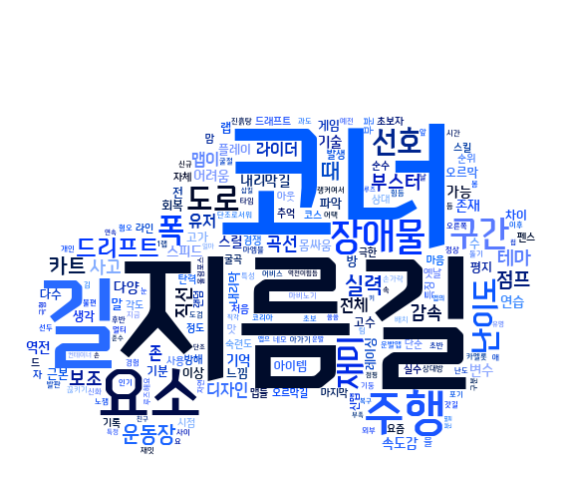

In [7]:
#count라는 데이터프레임을 사전형으로 변환
data = dict(zip(tmp['word'].tolist(), tmp['count'].tolist()))

wc = WordCloud(font_path='C:/Windows/Fonts/NEXONFootballGothicL.ttf', #폰트
               background_color='white',                              #배경색
               width=1600, height=800,                               #사이즈설정
                mask=mask)
#                max_words=200)                                         #단어갯수
cloud = wc.generate_from_frequencies(data)                            #사전형태 데이터

plt.figure(figsize=(10,10))                                           #액자사이즈설정
plt.axis('off')                                                       #테두리 선 없애기

plt.imshow(cloud.recolor(color_func = color_func),interpolation="bilinear")

# 저장
# plt.savefig('워드클라우드.png', bbox_inches='tight')